18.07.10

- ORM 개념
- SQL Alchemy
- SQLAlchemy ORM


### ORM 개념

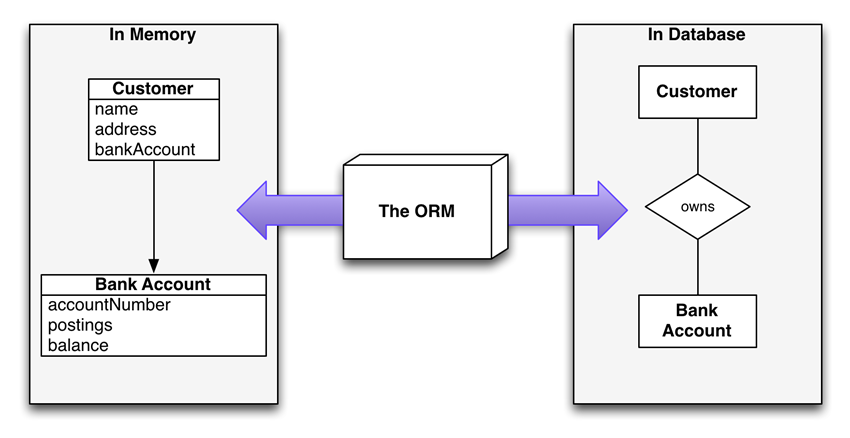

#### What is ORM?
- ORM stands Object Relational Mapping
- Programming technique for converting data between incompatible type systems using object-oriented programming languages 

클래스와 테이블의 매핑

복잡하게 sql쓰지말고 클래스가지고 작업하라 ORM이 엮어서 알아서 해준다, DBMS를 대신하는 프로그래밍 테크닉. 그러나 RDB는 밑에 반드시 존재해야

#### Why use ORM?
- Mismatch between the object model and the relational database
    - RDBSs represent data in tabular format
    - Object-Oriented languages represent data as an interconnected graph of objects
- ORM frees the programmer from dealing with simple repetitive database queries
- Automatically mapping the database to business objects
- Programmers focus more on business problems and less with data storage
- The mapping process can aid in data verification and security before reaching the database
- ORM can provide a caching layer above the database

sql 사용시 테이블 간 관계보다 DB처리에 cost가 많이 드는 경향

#### Disadvantages
Potentially increasing processing overhead


#### ORM in Python
- ORM allows a developer to write Python code instead of SQL to create, read, update and delete
    - Developers can use the programming language they are comfortable with to work with a database instead of writing SQL statements or stored procedures
- ORMs make it theoretically possible to switch an application between various relational databases
    - In practice however, it's best to use the same database for local development as is used in production


#### ORMs
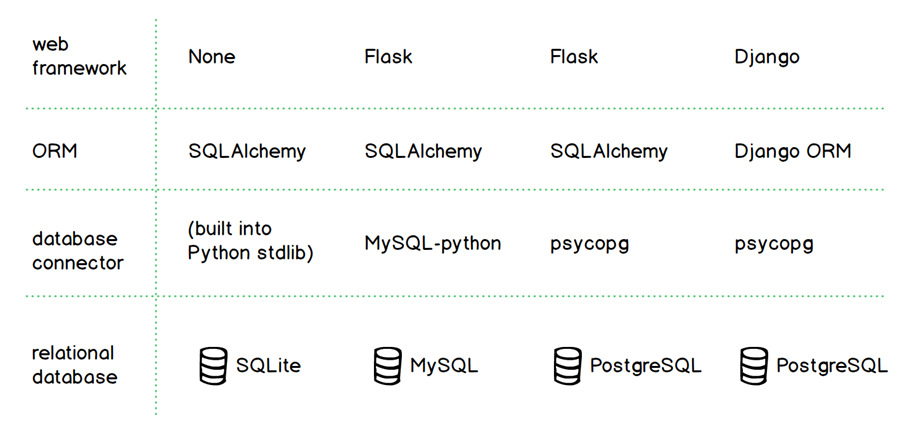

#### SQLAlchemy architecture
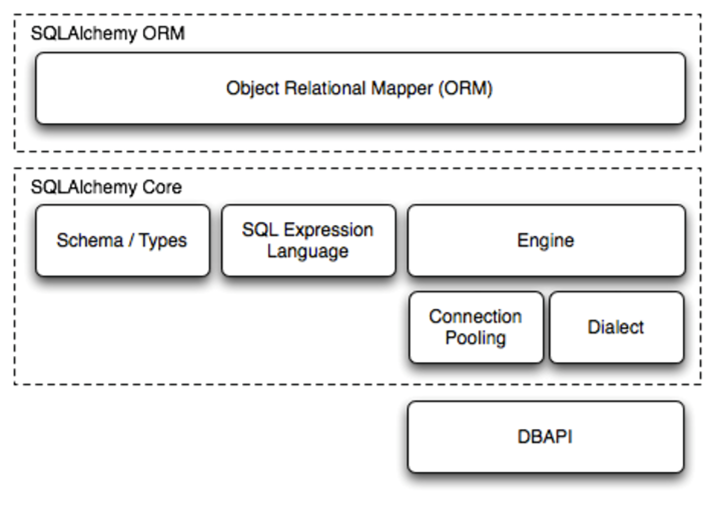

#### SQLAlchemy CORE
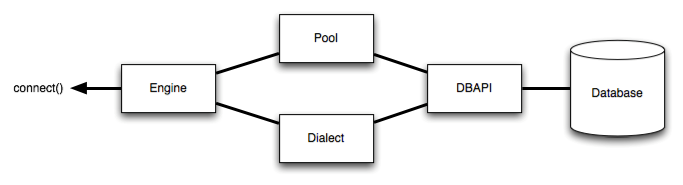
- Engine

starting point for any SQLAlchemy application
a registry which provides connectivity to a particular database server


엔진은 두가지로 구성
- Dialect
    - communicate with various types of DBAPI implementations and databases
    - interprets generic SQL and database commands in terms of specific - DBAPI and database backend
        - Firebird, Microsoft SQL Server, MySQL, Oracle, PostgreSQL, SQLite, Sybase

- Connection Pool

    - holds a collection of database connections in memory for fast re-use

In [50]:
import sqlalchemy

In [51]:
sqlalchemy.__version__

'1.2.1'

In [2]:
from sqlalchemy import create_engine

In [51]:
# sqlite://<nohostname>/<path>
engine = create_engine("sqlite:///alchemy_core_test.db", echo=False) #파일db이기에 호스트없음

In [52]:
print(engine)

#Lazy connecting
#The echo flag is a shortcut to setting up SQLAlchemy logging

Engine(sqlite:///alchemy_core_test.db)


In [5]:
from sqlalchemy import MetaData

In [53]:
metadata = MetaData()
print(metadata)

MetaData(bind=None)


In [7]:
from sqlalchemy import Table, Column, Integer, String, MetaData, ForeignKey

In [26]:
metadata = MetaData()

users = Table('users', metadata,
             Column('id',Integer,primary_key=True),
              Column('name',String),
              Column('fullname',String)
             )
address = Table('address',metadata,
               Column('id',Integer,primary_key=True),
                Column('user_id',None,ForeignKey('users.id')),
              Column('email_address',String, nullable=False)
               )

metadata.create_all(engine)


In [27]:
for row in metadata.tables:
    print(row)

users
address


In [63]:
users.insert() #Insert객체를 반환

In [64]:
print(users.insert()) # sql문의 형태

INSERT INTO users (id, name, fullname) VALUES (:id, :name, :fullname)


In [31]:
insert = users.insert().values(name='kim', fullname='Anonymous, Kim')
print(insert)

INSERT INTO users (name, fullname) VALUES (:name, :fullname)


In [32]:
insert.compile()

In [33]:
insert.compile().params

{'fullname': 'Anonymous, Kim', 'name': 'kim'}

In [34]:
insert

In [35]:
insert.bind = engine #binding option에 create된 engine을 주어 바인딩

- Connection

    - Provides high-level functionality for a wrapped DB-API connection
    - Provides execution support for string-based SQL statements as well as ClauseElement, Compiled and DefaultGenerator objects

In [54]:
conn = engine.connect() #엔진통해 실제 db와 연동

- execute

    - Executes a SQL statement construct and returns a ResultProxy


In [36]:
result  = conn.execute(insert) #실제 db에 insert

In [128]:
result.inserted_primary_key

[1]

In [129]:
conn.execute(insert, name='lee', fullname='Unknown, Lee')
#이렇게 insert가능 (이미 insert는 연동된 객체이므로)

In [130]:
conn.execute(address.insert(), [
    {'user_id':1,'email_address':'anonymous.kim@test.com'},
    {'user_id':2,'email_address':'unknown.lee@test.com'}
])

In [8]:
from sqlalchemy.sql import select

In [37]:
query = select([users])

In [38]:
print(query)

SELECT users.id, users.name, users.fullname 
FROM users


In [131]:
result = conn.execute(query)

In [132]:
for row in result:
    print(row) #row의 타입은 <class 'sqlalchemy.engine.result.RowProxy'>

(1, 'kim', 'Anonymous, Kim')
(2, 'lee', 'Unknown, Lee')


- ResultProxy

    - Wraps a DB-API cursor object to provide easier access to row columns

In [133]:
result = conn.execute(select([users.c.name, users.c.fullname])) 
#instance인 column을 특정해 가져옴

In [96]:
for row in result:
    print(row)

('kim', 'Anonymous, Kim')
('lee', 'Unknown, Lee')


#### Selecting

In [9]:
from sqlalchemy import and_, or_, not_

In [98]:
print(users.c.id == address.c.user_id) #실제 만들어지는 sql문

users.id = address.user_id


In [101]:
or_(users.c.id == address.c.user_id, users.c.id ==1)

In [102]:
print(or_(users.c.id == address.c.user_id, users.c.id ==1))

users.id = address.user_id OR users.id = :id_1


In [103]:
print((users.c.id == address.c.user_id | users.c.id ==1)) 
#사실 or_객체 없이도 파이썬 문법으로 가능

users.id = (address.user_id OR users.id)


In [134]:
result = conn.execute(select([users]).where(users.c.id==1))
for row in result:
    print(row)

(1, 'kim', 'Anonymous, Kim')


In [135]:
result = conn.execute(select([users, address]).where(users.c.id==address.c.user_id))
for row in result:
    print(row)

(1, 'kim', 'Anonymous, Kim', 1, 1, 'anonymous.kim@test.com')
(2, 'lee', 'Unknown, Lee', 2, 2, 'unknown.lee@test.com')


In [136]:
result = conn.execute(select([users]).where(users.c.name.like('k%')))
for row in result:
    print(row)

(1, 'kim', 'Anonymous, Kim')


In [139]:
result = conn.execute(select([users]).where(users.c.name.like('k%')).where(users.c.id==address.c.user_id))
print(select([users]).where(users.c.name.like('k%')).where(users.c.id==address.c.user_id)) #where절이 and로 묶임
for row in result:
    print(row)

SELECT users.id, users.name, users.fullname 
FROM users, address 
WHERE users.name LIKE :name_1 AND users.id = address.user_id
(1, 'kim', 'Anonymous, Kim')


#### Join

Return a Join from this FromClause to another FromClause

In [10]:
from sqlalchemy import join

In [141]:
print(users.join(address)) # on 없이도 PK, FK따라 알아서 해석

print(users.join(address, users.c.id == address.c.user_id)) #직접써도됨

users JOIN address ON users.id = address.user_id
users JOIN address ON users.id = address.user_id


In [142]:
query = select([users.c.id, users.c.fullname, address.c.email_address])\
                .select_from(users.join(address))

In [143]:
result = conn.execute(query).fetchall()
for row in result:
    print(row)

(1, 'Anonymous, Kim', 'anonymous.kim@test.com')
(2, 'Unknown, Lee', 'unknown.lee@test.com')


### 예제

In [55]:
artist = Table('Artist', metadata,
                Column('id', Integer, primary_key = True),
                Column('name',String,nullable=False))

album = Table('Album',metadata,
             Column('id',Integer,primary_key=True),
              Column('title', String, nullable = False),
              Column('artist_id',Integer, ForeignKey('Artist.id')))

genre = Table('Genre', metadata,
                Column('id', Integer, primary_key = True),
                Column('name',String,nullable=False))

track = Table('Track',metadata,
             Column('id',Integer,primary_key=True),
              Column('title', String, nullable = False),
              Column('length',Integer, nullable = False),
              Column('rating',Integer, nullable = False),
              Column('count',Integer, nullable = False),
              Column('album_id',Integer, ForeignKey('Album.id')),
              Column('genre_id',Integer, ForeignKey('Genre.id')))
              
metadata.create_all(engine)

In [40]:
tables = metadata.tables
for table in tables:
    print(table)

users
address
Artist
Album
Genre
Track


In [41]:
for table in engine.table_names():
    print(table)

Album
Artist
Genre
Track
address
users


In [42]:
users.drop(engine)
address.drop(engine)
#불필요한 테이블은 drop, binding 한 engine 알려주면 끝
# 그러나 metadata엔 클래스로 살아있음

In [56]:
conn.execute(artist.insert(),[
    {'name':'Led Zepplin'},
    {'name':'AC/DC'}
])
conn.execute(album.insert(),[
    {'title':'IV', 'artist_id':2},
    {'title':'Who Made Who', 'artist_id':2}
])
conn.execute(genre.insert(),[
    {'name':'Rock'},
    {'name':'Metal'}
])
conn.execute(track.insert(),[
    {'title':'Black Dog','rating':5,'length':297,'count':0,'album_id':1, 'genre_id':1},
    {'title':'Stairway','rating':5,'length':482,'count':0,'album_id':1, 'genre_id':1},
    {'title':'About to rock','rating':5,'length':313,'count':0,'album_id':2, 'genre_id':2},
    {'title':'Who Made Who','rating':5,'length':297,'count':0,'album_id':2, 'genre_id':2},
])

In [44]:
trackResult  = conn.execute(select([track])
                           .where(
                               and_(track.c.album_id==1, track.c.genre_id==1)
                           )
                        )
for row in trackResult:
    print(row)

(1, 'Black Dog', 297, 5, 0, 1, 1)
(2, 'Stairway', 482, 5, 0, 1, 1)


In [154]:
result = conn.execute(track.select().where(track.c.album_id==1)) 
#track에 내장한 select로 부른경우
for row in result:
    print(row)

(1, 'Black Dog', 297, 5, 0, 1, 1)
(2, 'Stairway', 482, 5, 0, 1, 1)


In [15]:
from sqlalchemy import update

In [17]:
conn.execute(track.update().values(genre_id=3).where(track.c.id==1))

In [158]:
print(track.join(album))

"Track" JOIN "Album" ON "Album".id = "Track".album_id


In [161]:
result = conn.execute(track.select().select_from(track.join(album)))
for row in result:
    print(row)

(1, 'Black Dog', 297, 5, 0, 1, 3)
(2, 'Stairway', 482, 5, 0, 1, 1)
(3, 'About to rock', 313, 5, 0, 2, 1)
(4, 'Who Made Who', 297, 5, 0, 2, 2)


In [163]:
result = conn.execute(select([track.c.title, album.c.title]).select_from(track.join(album)))
for row in result:
    print(row)

('Black Dog', 'IV')
('Stairway', 'IV')
('About to rock', 'Who Made Who')
('Who Made Who', 'Who Made Who')


In [165]:
print(track.join(album).join(genre).join(artist)) #join으로 연결하면됨

"Track" JOIN "Album" ON "Album".id = "Track".album_id JOIN "Genre" ON "Genre".id = "Track".genre_id


In [18]:
result = conn.execute(track.
                      select()
                     .select_from(track.join(album).join(genre).join(artist))
                     .where(
                         and_(
                                 genre.c.id==2,
                                 artist.c.id ==2
                             )
                         )
                     )
for row in result:
    print(row)

(3, 'About to rock', 313, 5, 0, 2, 2)
(4, 'Who Made Who', 297, 5, 0, 2, 2)


In [69]:
# open db
engine = create_engine("sqlite:///alchemy_core_test.db", echo =False)

metadata = MetaData(bind=engine) 
metadata.reflect(bind=engine) #Load all available table definitions from the database.

for row in metadata.tables:
    print(row)

Album
Artist
Genre
Track


In [66]:
tables = metadata.tables 
album = metadata.tables['Album']
track =  metadata.tables['Track']


In [67]:
track

Table('Track', MetaData(bind=Engine(sqlite:///alchemy_core_test.db)), Column('id', INTEGER(), table=<Track>, primary_key=True, nullable=False), Column('title', VARCHAR(), table=<Track>, nullable=False), Column('length', INTEGER(), table=<Track>, nullable=False), Column('rating', INTEGER(), table=<Track>, nullable=False), Column('count', INTEGER(), table=<Track>, nullable=False), Column('album_id', INTEGER(), ForeignKey('Album.id'), table=<Track>), Column('genre_id', INTEGER(), ForeignKey('Genre.id'), table=<Track>), schema=None)

In [73]:
conn = engine.connect()
with conn:
    for row in conn.execute(track.select()).fetchall():
        print(row)

(1, 'Black Dog', 297, 5, 0, 1, 1)
(2, 'Stairway', 482, 5, 0, 1, 1)
(3, 'About to rock', 313, 5, 0, 2, 2)
(4, 'Who Made Who', 297, 5, 0, 2, 2)


In [71]:
metadata.clear()

### SQLAlchemy ORM

In [123]:
from sqlalchemy import create_engine
engine = create_engine("sqlite:///Alchemy_ORM.db",echo=True)

In [124]:
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base() #base는 metadata와 유사

In [78]:
from sqlalchemy import Column, Integer, String, ForeignKey

In [125]:
class Artist(Base):
    __tablename__ = 'artist'
    
    _id = Column(Integer, primary_key=True)
    name = Column(String)
    
    def __repr__(self):
        return ("<Table artist(name= '%s' )>" % (self.name))
    
class Album(Base):
    __tablename__ = 'album'
    
    _id = Column(Integer, primary_key=True)
    title = Column(String)
    artist_id = Column(Integer, ForeignKey('artist._id'))
    
class Genre(Base):
    __tablename__ = 'genre'
    
    _id = Column(Integer, primary_key=True)
    name = Column(String)
    
class Track(Base):
    __tablename__ = 'track'
    
    _id = Column(Integer, primary_key=True)
    title = Column(String)
    album_id = Column(Integer, ForeignKey('album._id'))
    genre_id = Column(Integer, ForeignKey('genre._id'))
    

In [126]:
Base.metadata.create_all(engine)
#class 선언해 넘겨줬는데 테이블 생성

2018-07-10 17:27:11,717 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2018-07-10 17:27:11,719 INFO sqlalchemy.engine.base.Engine ()
2018-07-10 17:27:11,721 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2018-07-10 17:27:11,723 INFO sqlalchemy.engine.base.Engine ()
2018-07-10 17:27:11,726 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("artist")
2018-07-10 17:27:11,727 INFO sqlalchemy.engine.base.Engine ()
2018-07-10 17:27:11,730 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("album")
2018-07-10 17:27:11,731 INFO sqlalchemy.engine.base.Engine ()
2018-07-10 17:27:11,733 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("genre")
2018-07-10 17:27:11,735 INFO sqlalchemy.engine.base.Engine ()
2018-07-10 17:27:11,737 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("track")
2018-07-10 17:27:11,738 INFO sqlalchemy.engine.base.Engine ()
2018-07-10 17:27:11,740 INFO sqlalchemy.engin

In [127]:
artist1 = Artist(name="Led Zeppline")
artist2 = Artist(name="AC/DC")

In [128]:
artist1 #메모리에 존재하는 상태, db에 넣어줘야함

<Table artist(name= 'Led Zeppline' )>

In [91]:
from sqlalchemy.orm import sessionmaker

In [129]:
Session = sessionmaker(bind=engine) #세션을 통해 엔진이 바인딩

In [130]:
session = Session()

In [131]:
session.add_all((artist1, artist2)) 
# 엔진이 내부적으로 객체를 디비에 넣음

In [132]:
session.commit()

2018-07-10 17:27:39,242 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2018-07-10 17:27:39,244 INFO sqlalchemy.engine.base.Engine INSERT INTO artist (name) VALUES (?)
2018-07-10 17:27:39,246 INFO sqlalchemy.engine.base.Engine ('Led Zeppline',)
2018-07-10 17:27:39,250 INFO sqlalchemy.engine.base.Engine INSERT INTO artist (name) VALUES (?)
2018-07-10 17:27:39,251 INFO sqlalchemy.engine.base.Engine ('AC/DC',)
2018-07-10 17:27:39,253 INFO sqlalchemy.engine.base.Engine COMMIT


In [133]:
artist1.name = 'Led Zeppline Jr'

In [134]:
session.dirty # 메모리상의 값을 track해 db와 동기화 여부 파악

IdentitySet([<Table artist(name= 'Led Zeppline Jr' )>])

In [135]:
session.add_all([
    Album(title='1', artist_id = 1),
    Album(title='2', artist_id = 2)
])

In [136]:
session.new

IdentitySet([<__main__.Album object at 0x00000219B423EDD8>, <__main__.Album object at 0x00000219B423EB38>])

In [137]:
session.commit()

2018-07-10 17:27:58,499 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2018-07-10 17:27:58,501 INFO sqlalchemy.engine.base.Engine INSERT INTO album (title, artist_id) VALUES (?, ?)
2018-07-10 17:27:58,503 INFO sqlalchemy.engine.base.Engine ('1', 1)
2018-07-10 17:27:58,507 INFO sqlalchemy.engine.base.Engine INSERT INTO album (title, artist_id) VALUES (?, ?)
2018-07-10 17:27:58,508 INFO sqlalchemy.engine.base.Engine ('2', 2)
2018-07-10 17:27:58,511 INFO sqlalchemy.engine.base.Engine SELECT artist._id AS artist__id 
FROM artist 
WHERE artist._id = ?
2018-07-10 17:27:58,512 INFO sqlalchemy.engine.base.Engine (1,)
2018-07-10 17:27:58,515 INFO sqlalchemy.engine.base.Engine UPDATE artist SET name=? WHERE artist._id = ?
2018-07-10 17:27:58,516 INFO sqlalchemy.engine.base.Engine ('Led Zeppline Jr', 1)
2018-07-10 17:27:58,518 INFO sqlalchemy.engine.base.Engine COMMIT


In [138]:
session.add_all([
    Genre(name = 'Rock'),
    Genre(name = 'Metal')
])

In [139]:
session.commit()

2018-07-10 17:29:26,259 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2018-07-10 17:29:26,262 INFO sqlalchemy.engine.base.Engine INSERT INTO genre (name) VALUES (?)
2018-07-10 17:29:26,263 INFO sqlalchemy.engine.base.Engine ('Rock',)
2018-07-10 17:29:26,278 INFO sqlalchemy.engine.base.Engine INSERT INTO genre (name) VALUES (?)
2018-07-10 17:29:26,279 INFO sqlalchemy.engine.base.Engine ('Metal',)
2018-07-10 17:29:26,281 INFO sqlalchemy.engine.base.Engine COMMIT


In [145]:
session.add_all([
    Track(title = '1-1', album_id=1, genre_id = 1),
    Track(title = '2-1', album_id=2, genre_id = 2)
])

In [147]:
session.commit()

2018-07-10 17:31:48,363 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2018-07-10 17:31:48,366 INFO sqlalchemy.engine.base.Engine INSERT INTO track (title, album_id, genre_id) VALUES (?, ?, ?)
2018-07-10 17:31:48,367 INFO sqlalchemy.engine.base.Engine ('1-1', 1, 1)
2018-07-10 17:31:48,372 INFO sqlalchemy.engine.base.Engine INSERT INTO track (title, album_id, genre_id) VALUES (?, ?, ?)
2018-07-10 17:31:48,373 INFO sqlalchemy.engine.base.Engine ('2-1', 2, 2)
2018-07-10 17:31:48,375 INFO sqlalchemy.engine.base.Engine INSERT INTO track (title, album_id, genre_id) VALUES (?, ?, ?)
2018-07-10 17:31:48,376 INFO sqlalchemy.engine.base.Engine ('1-1', 1, 1)
2018-07-10 17:31:48,377 INFO sqlalchemy.engine.base.Engine INSERT INTO track (title, album_id, genre_id) VALUES (?, ?, ?)
2018-07-10 17:31:48,378 INFO sqlalchemy.engine.base.Engine ('2-1', 2, 2)
2018-07-10 17:31:48,380 INFO sqlalchemy.engine.base.Engine COMMIT


In [152]:
for row in session.query(Artist).filter(Artist._id==1):
    print(row.name)

2018-07-10 17:35:23,893 INFO sqlalchemy.engine.base.Engine SELECT artist._id AS artist__id, artist.name AS artist_name 
FROM artist 
WHERE artist._id = ?
2018-07-10 17:35:23,895 INFO sqlalchemy.engine.base.Engine (1,)
Led Zeppline Jr


In [1]:
#18.07.12
from sqlalchemy import create_engine

In [2]:
engine  = create_engine("sqlite:///Alchemy_ORM.db",echo=True)

#### automap

In [12]:
from sqlalchemy.ext.automap import automap_base
#reflect과정 필요
# 앞서 declarative_base 로 비어있는 Base를 생성했던 것과 달리
#자동으로 데이터를 받아와  Base 객체에 매핑

In [13]:
Base = automap_base()

In [14]:
Base.prepare(engine,reflect=True)

2018-07-12 10:52:57,259 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2018-07-12 10:52:57,273 INFO sqlalchemy.engine.base.Engine ()
2018-07-12 10:52:57,275 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2018-07-12 10:52:57,276 INFO sqlalchemy.engine.base.Engine ()
2018-07-12 10:52:57,279 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2018-07-12 10:52:57,281 INFO sqlalchemy.engine.base.Engine ()
2018-07-12 10:52:57,285 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("album")
2018-07-12 10:52:57,286 INFO sqlalchemy.engine.base.Engine ()
2018-07-12 10:52:57,290 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'album' AND type = 'table'
2018-07-12 10:52:57,290 INFO sqlalchemy.engine.base.Engine ()
2018-07-12 10:52:57,293 INFO sqlalchemy.engine.base.

In [15]:
from sqlalchemy.orm import sessionmaker

In [16]:
Session = sessionmaker(bind=engine)
#세션은 db에 쓸 때만 필요

In [17]:
session = Session()

In [18]:
artist = Base.classes.artist

In [19]:
artist #클래스 자체가 아니라 클래스를 오토맵으로 감싼 형태

sqlalchemy.ext.automap.artist

In [20]:
artist.name

In [21]:
result = session.query(artist)

In [22]:
type(result) #automap 이용했기에 바로 출력안되는 객체

sqlalchemy.orm.query.Query

In [17]:
for row in result:
    print(type(row))
    print(row._id, row.name) #클래스 어트리뷰트 접근하듯이 

2018-07-12 10:30:19,074 INFO sqlalchemy.engine.base.Engine SELECT artist._id AS artist__id, artist.name AS artist_name 
FROM artist
2018-07-12 10:30:19,076 INFO sqlalchemy.engine.base.Engine ()
<class 'sqlalchemy.ext.automap.artist'>
1 Led Zeppline Jr
<class 'sqlalchemy.ext.automap.artist'>
2 AC/DC


### Relationship

    - db의 relationship을 클래스에 알려주는 작업

    - relationship
        - Provide a relationship between two mapped classes
        - This corresponds to a parent-child or associative table relationship

    - back_populates / backref
        - indicates the string name of a property to be placed on the related mapper’s class that will handle this relationship in the other direction

    - uselist
        - a boolean that indicates if this property should be loaded as a list or a scalar
        - N:N 관계가 기본, uselist 옵션으로 조정

In [25]:
#커널 재시작 필요
from sqlalchemy.orm import relationship
from sqlalchemy import create_engine
from sqlalchemy import Column, Integer, String, ForeignKey
from sqlalchemy.ext.declarative import declarative_base

In [26]:
Base = declarative_base() # 앞서 정의한 아래 클래스들 사용위해 declarative_base

In [27]:
class Artist(Base):
    __tablename__ = 'artist'
    
    _id = Column(Integer, primary_key=True)
    name = Column(String)
    #relationship 객체 추가
    album = relationship('Album', back_populates='artist')
    
    def __repr__(self):
        return ("<Table artist(name= '%s' )>" % (self.name))
    
class Album(Base):
    __tablename__ = 'album'
    
    _id = Column(Integer, primary_key=True)
    title = Column(String)
    artist_id = Column(Integer, ForeignKey('artist._id'))
    #
    artist = relationship("Artist", back_populates='album', uselist = False)
    #Artist 클래스와 관계가 있고 역으로 추적하면 album을 만날수있다
    
class Genre(Base):
    __tablename__ = 'genre'
    
    _id = Column(Integer, primary_key=True)
    name = Column(String)
    
class Track(Base):
    __tablename__ = 'track'
    
    _id = Column(Integer, primary_key=True)
    title = Column(String)
    album_id = Column(Integer, ForeignKey('album._id'))
    genre_id = Column(Integer, ForeignKey('genre._id'))
    

In [28]:
artist1 = Artist(name='Led Zeppline' )

In [29]:
artist1.album = [Album(title='IV'), Album(title="Who who")]

In [32]:
print( artist1.name, artist1.album[0].title, artist1.album[1].title)
# artisit1 Led Zepplin이 album IV ,Who who 와 관계있는데
# artisit1의 어트리뷰트로 직접 album 리스트를 갖는 모양
# 클래스 딴의 이야기

Led Zeppline IV Who who


In [33]:
artist1.album[0].title = 'test' #그냥 수정도 가능

In [35]:
print(  artist1.album[0].title)

test


In [37]:
session = Session()

In [38]:
session.add(artist1)

In [40]:
session.commit()

2018-07-12 11:00:37,868 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2018-07-12 11:00:37,871 INFO sqlalchemy.engine.base.Engine INSERT INTO artist (name) VALUES (?)
2018-07-12 11:00:37,873 INFO sqlalchemy.engine.base.Engine ('Led Zeppline',)
2018-07-12 11:00:37,878 INFO sqlalchemy.engine.base.Engine INSERT INTO album (title, artist_id) VALUES (?, ?)
2018-07-12 11:00:37,880 INFO sqlalchemy.engine.base.Engine ('test', 3)
2018-07-12 11:00:37,882 INFO sqlalchemy.engine.base.Engine INSERT INTO album (title, artist_id) VALUES (?, ?)
2018-07-12 11:00:37,883 INFO sqlalchemy.engine.base.Engine ('Who who', 3)
2018-07-12 11:00:37,885 INFO sqlalchemy.engine.base.Engine COMMIT
